<a href="https://colab.research.google.com/github/FKz11/Neural_Network/blob/lesson-4/lesson_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## lesson-4

Библиотеки

In [1]:
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [3]:
# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10)

In [4]:
def nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 12, start_kernel = 3, neurons = 2000, batch_size = 32, epochs = 5):
    
    first_layer = np.empty(branch, dtype=object)
    
    first_input = layers.Input(shape=x_train.shape[1:]) # shape = (32, 32, 3)

    for i in range(branch):
      if i > 1:                                                                                                                        # filters = 12, 12, 24, 48
        conv = layers.Conv2D(start_filters*2**(i-1),2*(branch-1) + start_kernel - 2*i,activation='relu',padding = 'same')(first_input) # kernel_size = 9, 7, 5, 3
        first_layer[i] = layers.MaxPool2D(pool_size=(2**(i-1),2**(i-1)))(conv)                                                         # pool_size = 1, 1, 2, 4
      else:
        first_layer[i] = layers.Conv2D(start_filters,2*(branch-1) + start_kernel - 2*i,activation='relu',padding = 'same')(first_input)

    layer_list = first_layer.copy()

    for i in range(branch-1):
      merge = layers.Concatenate(  axis =-1 )([layer_list[i], first_layer[i+1]])                                                   # filters = 24, 48, 96
      conv = layers.Conv2D(start_filters*2**(i+1),2*(branch-1) + start_kernel - 2*(i+1),activation='relu',padding = 'same')(merge) # kernel_size = 7, 5, 3
      layer_list[i+1] = layers.MaxPool2D(pool_size=(2,2))(conv)

    flatten = layers.Flatten()(layer_list[branch-1]) # input_shape = (4, 4, 96)
    
    dense_one=layers.Dense(neurons, activation='relu')(flatten) # input_shape = (1536)
    
    dense_two=layers.Dense(y_train.shape[1], activation='softmax')(dense_one)
    
    model = Model(inputs=first_input, outputs=dense_two)
    
    # компиляция модели
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    hh = model.fit(x_train, y_train, shuffle=True,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_test, y_test))
    
    return model, {key: value[-1] for key, value in hh.history.items()}

In [5]:
model, hh = nn_conv(x_train, x_test, y_train, y_test, branch = 4, start_filters = 12, start_kernel = 3, neurons = 2000, batch_size = 32, epochs = 5)

Epoch 1/5
1563/1563 [==============================] - 49s 30ms/step - loss: 1.3580 - accuracy: 0.5083 - val_loss: 1.0498 - val_accuracy: 0.6258
Epoch 2/5
1563/1563 [==============================] - 43s 28ms/step - loss: 0.9537 - accuracy: 0.6634 - val_loss: 0.9673 - val_accuracy: 0.6643
Epoch 3/5
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7826 - accuracy: 0.7230 - val_loss: 0.8124 - val_accuracy: 0.7204
Epoch 4/5
1563/1563 [==============================] - 42s 27ms/step - loss: 0.6447 - accuracy: 0.7713 - val_loss: 0.8177 - val_accuracy: 0.7181
Epoch 5/5
1563/1563 [==============================] - 44s 28ms/step - loss: 0.5262 - accuracy: 0.8156 - val_loss: 0.8423 - val_accuracy: 0.7271


In [6]:
hh

{'accuracy': 0.8155999779701233,
 'loss': 0.5261967778205872,
 'val_accuracy': 0.7271000146865845,
 'val_loss': 0.8422777056694031}

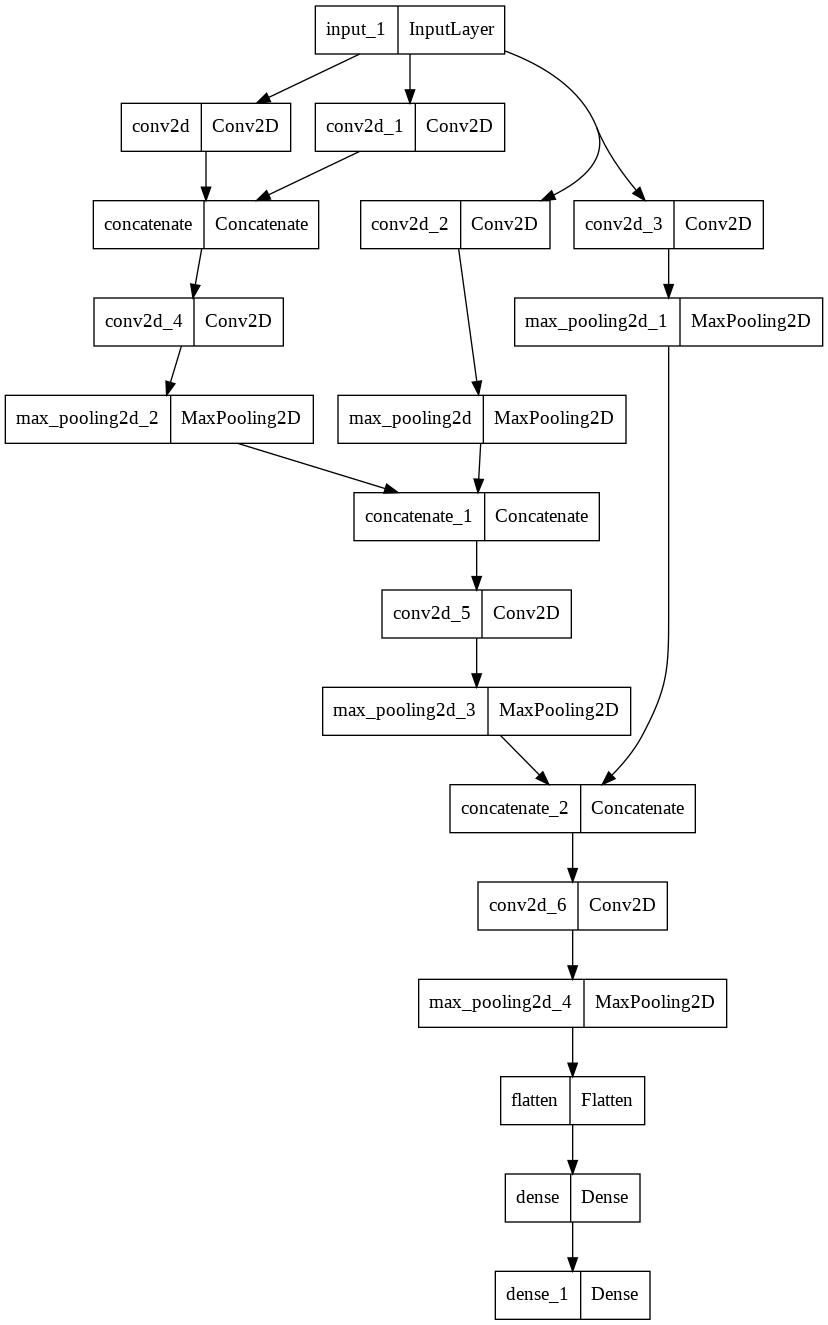

In [7]:
plot_model(model)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 12)   2928        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 12)   1776        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 24)   0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]']           

#### Вывод:

Я постарался сделать необычную нелинейную свёрточную нейронную сеть, учитывая заканомерности изученной сети AlexNet, а точнее: сначала задаём большой размер ядра для свёртки, далее уменьшаем размер ядра свёртки, увиличиваем количество фильтров и используем связки, свёртка - пулинг. Далее выпремляем наш конечный тензор, прогоняем его через полносвязный нейронный слой и выводим на конечные 10 выходных нейронов наш ответ в вероятностном виде (от 0 до 1) с помощью функции активации softmax.

Идея моей нейронной сети, чтобы на каждом этапе свёртка - пулинг, нейронная сеть вспоминала изначальные данные той же размерности и свёрнутые ядром одного размера. Такая компоновка данных на каждом этапе, должна давать более интересные резуьтаты, чем обычная линейная модель.

Можно поэксперементировать с гиперпараметрами этой сети, это должно улучшить метрику.

(Я не успел пока что проделать эксперименты, так как я очень долго мучался, чтобы правильно настроить CUDA и Cudnn, я вроде бы всё сделал правильно, но всё равно ничего не получается. Поэтому я в срочном порядке начал осваивать google-colab).

Завтра сделаю все эксперименты (29.03.2022).